## Database setup and statistical analysis


<div class="alert alert-block alert-warning"><b>Example:</b>NOTE: Tables 0:2 are required for querying spacial data and converting between coordinate systems. Do not modify or remove. Origin, FEMA_NRI, see readme for more information.</div>





In [14]:
# import libraries
# NOTE: global_vars should be edited to include local paths and credentials before use.
import ignore.global_vars as gv
import db_tools as dbt
import pandas as pd
import sqlalchemy
import sys
from IPython.display import display, HTML
from scipy import stats
from scipy.stats import poisson, nbinom
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap
import plotly.express as px
import plotly.graph_objects as go
from shapely import wkt
import os

In [ ]:
# NOTE: Set to True if a full rebuild is required, set to False to skip table builds. Search 'REBUILD_TABLE' to see which sections are effected.
REBUILD = False

In [16]:
# open connection and get table names
table_names = dbt.query("SELECT table_name FROM information_schema.tables WHERE table_schema='public'")
print(table_names)


Created SQLAlchemy engine for disaster_db
Query executed successfully, returned 12 rows
                             table_name
0                     census_resilience
1                     geography_columns
2                      geometry_columns
3                       spatial_ref_sys
4              POISSON_FREQUENCY_PARAMS
5               nri_shape_census_tracts
6              noaa_stormevents_ftp_all
7                   NOAA_STORM_EPISODES
8                 disaster_risk_spatial
9        disaster_risk_counties_spatial
10                    NOAA_STORM_EVENTS
11  disaster_risk_counties_event_counts


### Fitting Poisson distributions to historical disaster event counts ###


Poission process was chosen for disaster occurence due to:
- Right-tail skewed distribution
- Data is random
- Data is discrete
- Data is random
- Data is time series 



$$P(N_{i,t} = k) = \frac{\lambda_i^k e^{-\lambda_i}}{k!}$$

Where:  
$N_{i,t}$ = number of disaster episodes in county $i$ during year $t$  
$k$ = observed count (0, 1, 2, 3, ...)  
$\lambda_i$ = county-specific rate parameter (average annual episodes)  
$e$ = Euler's number (≈ 2.718)  
$k!$ = factorial of $k$  

$$N_{i,t} \sim \text{P}(\lambda_i)$$

Where:  
$N_{i,t}$ = number of disaster episodes in county $i$ during year $t$  
$\lambda_i$ = county-specific average annual episode rate  


---

\begin{align}
N_i &\sim \text{Poisson}(\lambda_i) \quad \text{[Frequency from NOAA]} \\
Y_{i,j} &\sim F_i(\theta_i) \quad \text{[Severity from Census/NOAA]} \\
S_i &= \sum_{j=1}^{N_i} Y_{i,j} \quad \text{[Total Risk]}
\end{align}

Where:
- N ~ Poisson(λ)           [Number of events from NOAA]
- Yi ~ Severity Distribution [Potential impact per event from Census data as vunerability]
- λ = NOAA historical event frequency
- Yi = f(population, vulnerability, demographics)

In [17]:
geography_columns = dbt.query("SELECT * FROM geography_columns")


Created SQLAlchemy engine for disaster_db
Query executed successfully, returned 0 rows


In [18]:
# Load the NOAA data into a DataFrame for analysis
df_noaa = dbt.query("SELECT * FROM \"NOAA_STORM_EPISODES\" ORDER BY county_fips, year")


Created SQLAlchemy engine for disaster_db
Query executed successfully, returned 107094 rows


In [19]:
# Basic data exploration of NOAA episodes
print("=== NOAA EPISODES DATA EXPLORATION ===")
print(f"DataFrame shape: {df_noaa.shape}")
print(f"Columns: {list(df_noaa.columns)}")
print(f"Data types:")
print(df_noaa.dtypes)

print(f"\n=== BASIC STATISTICS ===")
print(f"Year range: {df_noaa['year'].min()} - {df_noaa['year'].max()}")
print(f"Unique counties: {df_noaa['county_fips'].nunique()}")
print(f"Total county-year records: {len(df_noaa)}")
print(f"Event count statistics:")
print(df_noaa['event_count'].describe())

=== NOAA EPISODES DATA EXPLORATION ===
DataFrame shape: (107094, 9)
Columns: ['county_fips', 'year', 'event_count', 'total_deaths_direct', 'total_deaths_indirect', 'total_injuries_direct', 'total_injuries_indirect', 'event_types', 'first_event_date']
Data types:
county_fips                        object
year                                int64
event_count                         int64
total_deaths_direct                 int64
total_deaths_indirect               int64
total_injuries_direct               int64
total_injuries_indirect             int64
event_types                        object
first_event_date           datetime64[ns]
dtype: object

=== BASIC STATISTICS ===
Year range: 1999 - 2024
Unique counties: 4119
Total county-year records: 107094
Event count statistics:
count    107094.000000
mean          0.206921
std           0.658732
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          29.000000
Name: event_count, dtype: float

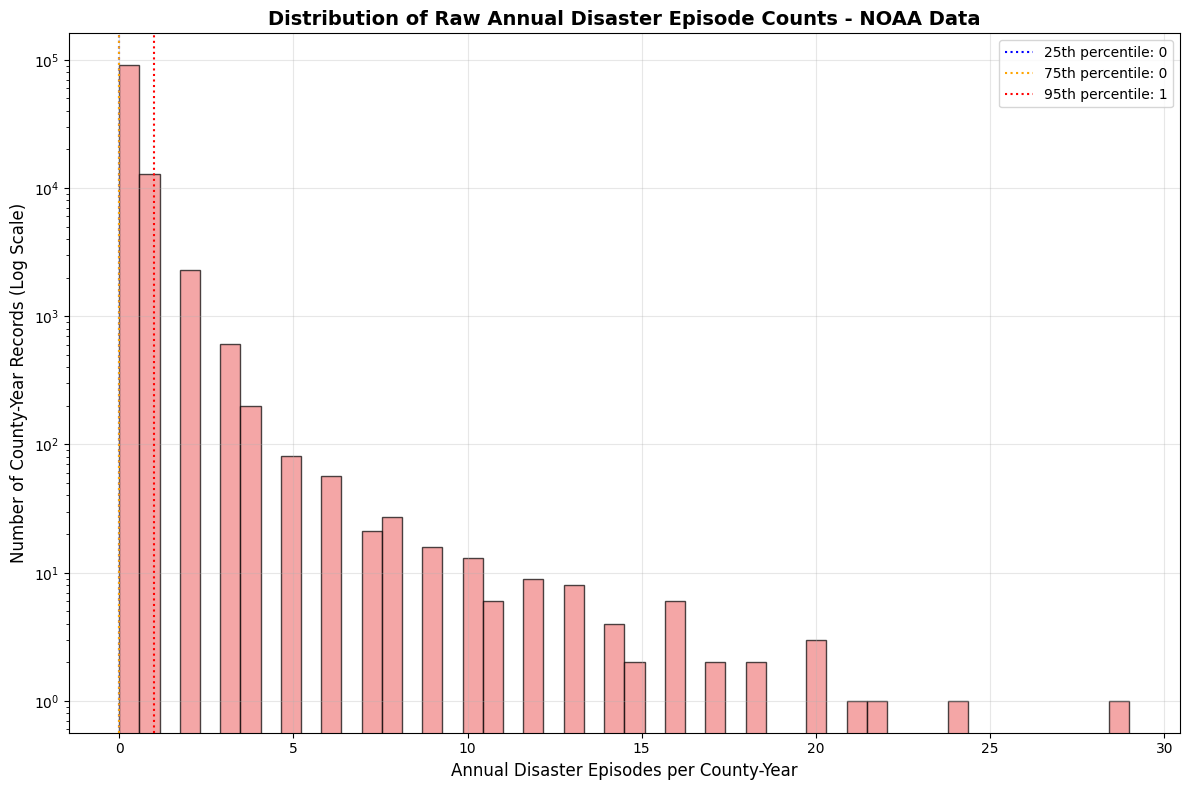

In [20]:
# Create histogram of raw event counts with log scale for distribution analysis
plt.figure(figsize=(12, 8))
plt.hist(df_noaa['event_count'], bins=50, alpha=0.7, edgecolor='black', color='lightcoral')
plt.xlabel('Annual Disaster Episodes per County-Year', fontsize=12)
plt.ylabel('Number of County-Year Records (Log Scale)', fontsize=12)
plt.title('Distribution of Raw Annual Disaster Episode Counts - NOAA Data', fontsize=14, fontweight='bold')
plt.yscale('log')

# Add percentiles to help interpretation with log scale
raw_counts = df_noaa['event_count']
p25_raw = raw_counts.quantile(0.25)
p75_raw = raw_counts.quantile(0.75)
p95_raw = raw_counts.quantile(0.95)

plt.axvline(p25_raw, color='blue', linestyle=':', label=f'25th percentile: {p25_raw:.0f}')
plt.axvline(p75_raw, color='orange', linestyle=':', label=f'75th percentile: {p75_raw:.0f}')
plt.axvline(p95_raw, color='red', linestyle=':', label=f'95th percentile: {p95_raw:.0f}')

plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [21]:
# get summary statistics for each county. Group by county_fips
county_lambdas = df_noaa.groupby('county_fips').agg({
    'event_count': ['mean', 'var', 'std', 'count', 'sum'],
    'year': ['min', 'max']
}).round(4)

# Flatten column names
county_lambdas.columns = ['_'.join(col).strip() for col in county_lambdas.columns]
county_lambdas = county_lambdas.reset_index()

# Rename for clarity
county_lambdas.rename(columns={
    'event_count_mean': 'lambda_hat',
    'event_count_var': 'variance', 
    'event_count_std': 'std_dev',
    'event_count_count': 'years_observed',
    'event_count_sum': 'total_events',
    'year_min': 'first_year',
    'year_max': 'last_year'
}, inplace=True)

# Calculate overdispersion ratio (variance/mean)
county_lambdas['overdispersion_ratio'] = np.where(
    county_lambdas['lambda_hat'] > 0,
    county_lambdas['variance'] / county_lambdas['lambda_hat'],
    np.nan
)

# Add these lines to see output:
print(f"Processed {len(county_lambdas)} counties")
print(f"Lambda statistics:")
print(county_lambdas["lambda_hat"].describe())
print("\nFirst few rows:")
print(county_lambdas.head())

Processed 4119 counties
Lambda statistics:
count    4119.000000
mean        0.206925
std         0.330591
min         0.038500
25%         0.076900
50%         0.115400
75%         0.230800
max         8.269200
Name: lambda_hat, dtype: float64

First few rows:
  county_fips  lambda_hat  variance  std_dev  years_observed  total_events  \
0       01001      0.5769    0.4138   0.6433              26            15   
1       01002      0.2692    0.2846   0.5335              26             7   
2       01003      1.2308    1.6246   1.2746              26            32   
3       01004      0.0769    0.0738   0.2717              26             2   
4       01005      0.3077    0.3815   0.6177              26             8   

   first_year  last_year  overdispersion_ratio  
0        1999       2024              0.717282  
1        1999       2024              1.057207  
2        1999       2024              1.319955  
3        1999       2024              0.959688  
4        1999       2024 

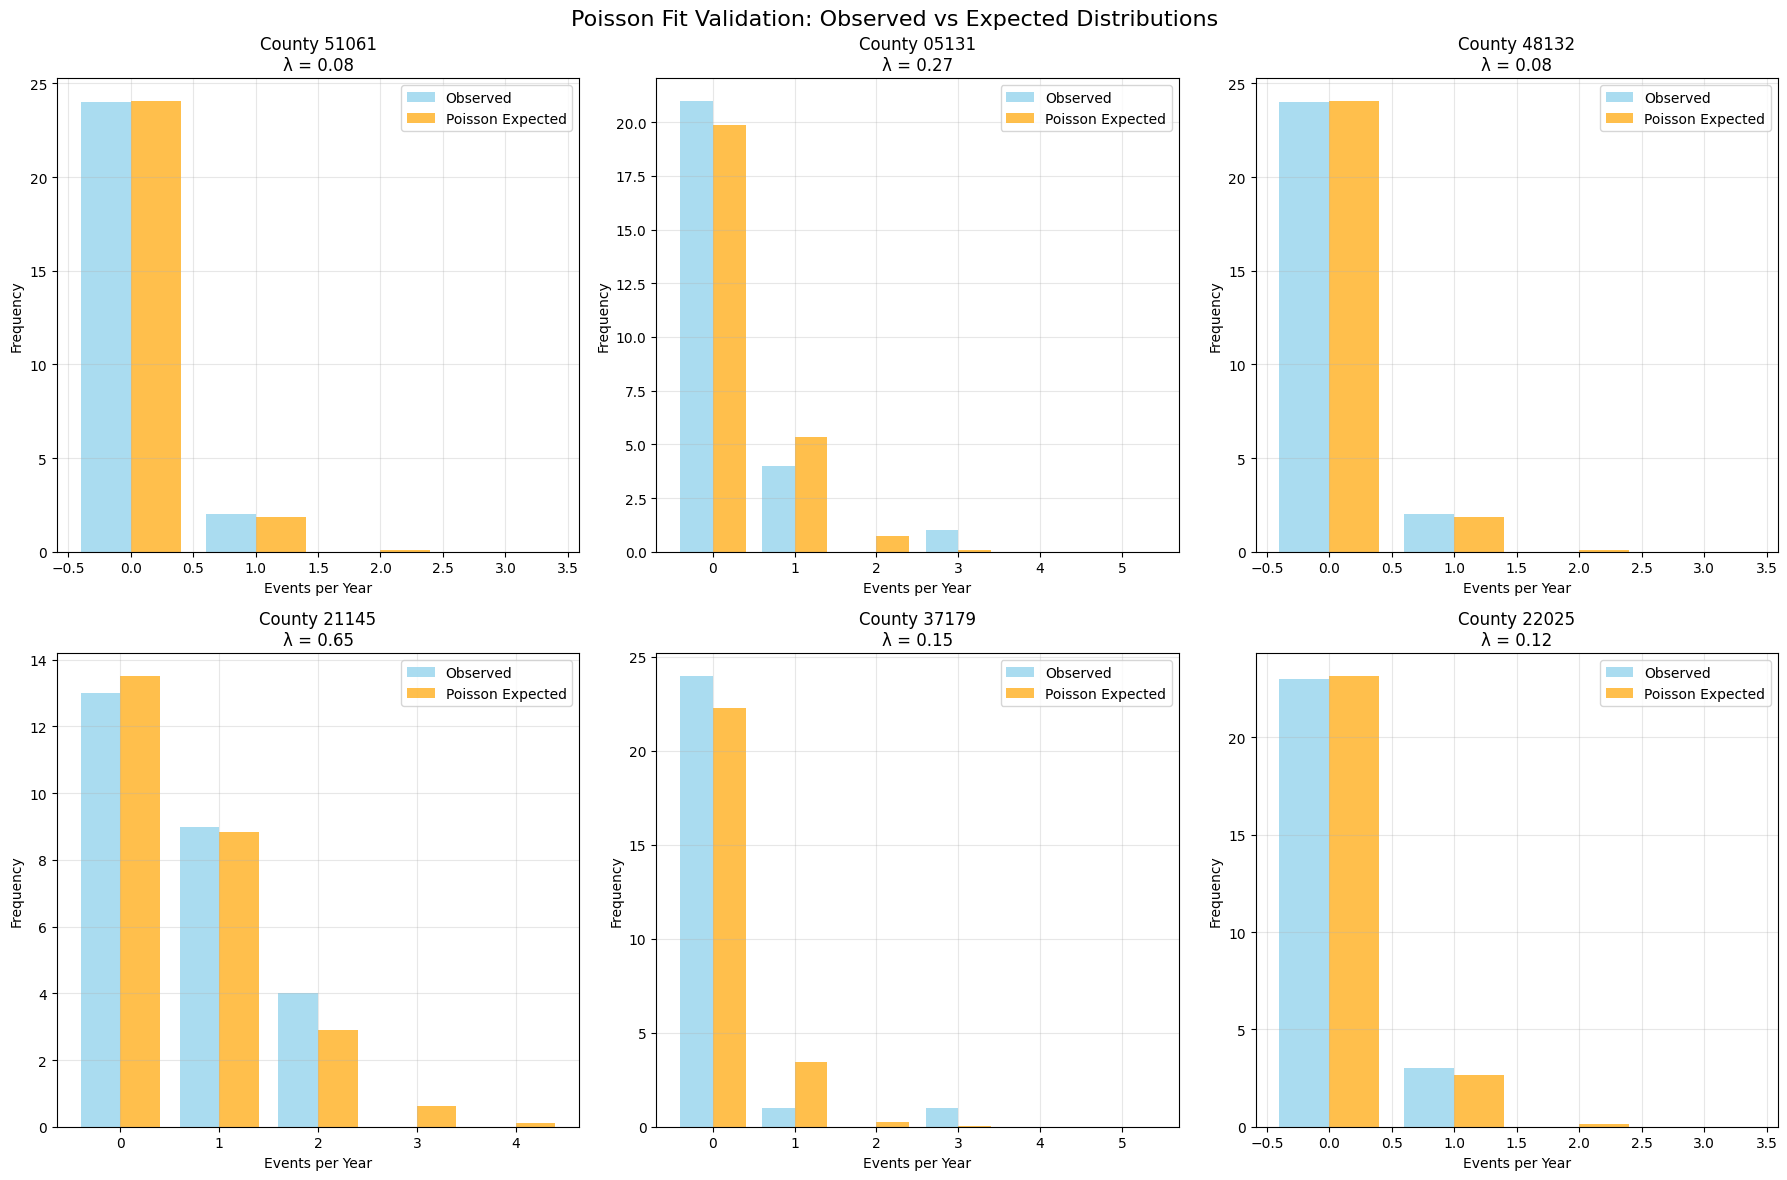

In [22]:
# Sample 6 counties for fit validation
sample_counties = county_lambdas.sample(6, random_state=36)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, (_, county) in enumerate(sample_counties.iterrows()):
    county_fips = county['county_fips']
    lambda_est = county['lambda_hat']

    county_data = df_noaa[df_noaa['county_fips'] == county_fips]['event_count']
    max_events = int(county_data.max()) + 2
    x_vals = range(0, max_events + 1)
    theoretical_probs = [poisson.pmf(k, lambda_est) for k in x_vals]
    theoretical_counts = [p * len(county_data) for p in theoretical_probs]
    actual_counts = [sum(county_data == k) for k in x_vals]
    axes[i].bar([x - 0.2 for x in x_vals], actual_counts, width=0.4, 
                label='Observed', alpha=0.7, color='skyblue')
    axes[i].bar([x + 0.2 for x in x_vals], theoretical_counts, width=0.4, 
                label='Poisson Expected', alpha=0.7, color='orange')
    
    axes[i].set_title(f'County {county_fips}\nλ = {lambda_est:.2f}')
    axes[i].set_xlabel('Events per Year')
    axes[i].set_ylabel('Frequency')
    axes[i].legend()
    axes[i].grid(alpha=0.3)

plt.suptitle('Poisson Fit Validation: Observed vs Expected Distributions', fontsize=16)
plt.tight_layout()
plt.show()

In [23]:
# make a dataframe of the poisson risk parameters
poisson_risk_params = county_lambdas[['county_fips', 'lambda_hat', 'years_observed', 'total_events']].copy()

# Add confidence intervals for lambda estimates NOTE: not yet implemented, generating these in case we need them
poisson_risk_params['lambda_se'] = np.sqrt(poisson_risk_params['lambda_hat'] / poisson_risk_params['years_observed'])
poisson_risk_params['lambda_ci_lower'] = poisson_risk_params['lambda_hat'] - 1.96 * poisson_risk_params['lambda_se']
poisson_risk_params['lambda_ci_upper'] = poisson_risk_params['lambda_hat'] + 1.96 * poisson_risk_params['lambda_se']

# set any negative lower CI bounds to zero
poisson_risk_params['lambda_ci_lower'] = np.maximum(0, poisson_risk_params['lambda_ci_lower'])

# calculate the probability of at least one event in a year
# P(≥1 disaster) = 1 - e^(-λ)
poisson_risk_params["prob_at_least_one_event"] = 1 - np.exp(
    -poisson_risk_params["lambda_hat"]
)

In [24]:
# Create spatial database table for QGIS access
if REBUILD:
    print("Loading NRI shapefile data...")
    nri_gdf = dbt.query("""
        SELECT 
            "STCOFIPS" as county_fips,
            ST_AsText("geometry") as geometry_wkt,
            "TRACTFIPS" as tract_geoid,
            "POPULATION",
            "RISK_SCORE"
        FROM nri_shape_census_tracts
        WHERE "geometry" IS NOT NULL
        AND "STCOFIPS" IS NOT NULL
    """)

    if len(nri_gdf) > 0:
        print(f"Loaded {len(nri_gdf)} census tracts")
        
        # Convert WKT to geometries for processing
        nri_gdf['geometry'] = nri_gdf['geometry_wkt'].apply(wkt.loads)
        nri_gdf = gpd.GeoDataFrame(nri_gdf, geometry='geometry')
        
        # Aggregate to county level
        print("Aggregating to county boundaries...")
        county_boundaries = nri_gdf.dissolve(by='county_fips').reset_index()
        county_boundaries = county_boundaries[['county_fips', 'geometry']]
        
        # Merge with lambda data
        print("Merging with Poisson lambda estimates...")
        lambda_map_data = county_boundaries.merge(
            poisson_risk_params[
                [
                    "county_fips",
                    "lambda_hat",
                    "total_events",
                    "years_observed",
                    "lambda_ci_lower",
                    "lambda_ci_upper",
                    "prob_at_least_one_event"
                ]
            ],
            on="county_fips",
            how="left",
        )
        
        # Impute missing lambda values using state averages
        # NOTE: check statistical justification. Clean data, fill missing county data with state averages
        lambda_map_data['state_fips'] = lambda_map_data['county_fips'].str[:2]
        state_avg = lambda_map_data.groupby('state_fips')['lambda_hat'].mean()
        lambda_map_data['lambda_hat'] = lambda_map_data['lambda_hat'].fillna(
            lambda_map_data['state_fips'].map(state_avg)
        )
        # calculate the probability of at least one event in a year (survival function)
        # P(≥1 disaster) = 1 - e^(-λ)
        lambda_map_data['prob_at_least_one_event'] = 1 - np.exp(-lambda_map_data['lambda_hat'])
        overall_mean = lambda_map_data['lambda_hat'].mean()
        lambda_map_data['lambda_hat'] = lambda_map_data['lambda_hat'].fillna(overall_mean)
        lambda_map_data['total_events'] = lambda_map_data['total_events'].fillna(0)
        lambda_map_data['years_observed'] = lambda_map_data['years_observed'].fillna(10)
        lambda_map_data['lambda_se'] = np.sqrt(lambda_map_data['lambda_hat'] / lambda_map_data['years_observed'])
        lambda_map_data['lambda_ci_lower'] = np.maximum(0, lambda_map_data['lambda_hat'] - 1.96 * lambda_map_data['lambda_se'])
        lambda_map_data['lambda_ci_upper'] = lambda_map_data['lambda_hat'] + 1.96 * lambda_map_data['lambda_se']


        # make a clean copy for QGIS
        lambda_map_clean = lambda_map_data.copy()
        
        # Add useful columns for QGIS
        lambda_map_clean['lambda_rounded'] = lambda_map_clean['lambda_hat'].round(3)
        
        print(f"Prepared {len(lambda_map_clean)} counties with complete data")
        
        # Convert geometry back to WKT for database storage
        lambda_map_clean['geometry_wkt'] = lambda_map_clean['geometry'].apply(lambda x: x.wkt)
        
        # Prepare data for database (drop geometry column, keep WKT)
        db_data = lambda_map_clean.drop('geometry', axis=1)
        
        # Save to database
        print("Saving spatial data to database...")
        dbt.load_data(db_data, "disaster_risk_spatial", if_exists="replace")
        
        # Create spatial table with PostGIS geometry
        print("Creating PostGIS spatial table...")
        spatial_table_sql = """
        DROP TABLE IF EXISTS disaster_risk_counties_spatial;

        CREATE TABLE disaster_risk_counties_spatial AS
        SELECT 
            county_fips,
            lambda_hat,
            lambda_rounded,
            prob_at_least_one_event,
            total_events,
            years_observed,
            lambda_ci_lower,
            lambda_ci_upper,
            ST_GeomFromText(geometry_wkt, 4326) as geometry
        FROM disaster_risk_spatial;

        -- Add spatial index for performance
        CREATE INDEX idx_disaster_risk_counties_spatial_geom 
        ON disaster_risk_counties_spatial USING GIST (geometry);

        -- Add primary key
        ALTER TABLE disaster_risk_counties_spatial 
        ADD CONSTRAINT pk_disaster_risk_counties_spatial PRIMARY KEY (county_fips);
        """
        
        dbt.execute_sql(spatial_table_sql)
        print("Spatial database table created: disaster_risk_counties_spatial")
    else:
        print("No geographic data available")
else: 
    print("Skip rebuilding table")

Loading NRI shapefile data...
Created SQLAlchemy engine for disaster_db
Query executed successfully, returned 85154 rows
Loaded 85154 census tracts
Aggregating to county boundaries...
Merging with Poisson lambda estimates...
Prepared 3231 counties with complete data
Saving spatial data to database...
Created SQLAlchemy engine for disaster_db
Data loaded successfully into disaster_risk_spatial
Creating PostGIS spatial table...
Connection established
SQL executed successfully
Spatial database table created: disaster_risk_counties_spatial


next steps
Severity modeling using census resilience data
Compound model integration (frequency × severity)
Risk scenario simulation
Geographic risk mapping

In [25]:
# create table for disaster counts by county
if REBUILD:
    event_types_sql = """
    SELECT DISTINCT "EVENT_TYPE" 
    FROM "NOAA_STORM_EVENTS" 
    WHERE ("INJURIES_DIRECT" > 0 OR "DEATHS_DIRECT" > 0)
    ORDER BY "EVENT_TYPE";
    """

    event_types = dbt.query(event_types_sql)
    # Build dynamic pivot columns
    pivot_columns = []
    for event_type in event_types["EVENT_TYPE"]:
        safe_name = (
            event_type.lower()
            .replace(" ", "_")
            .replace("-", "_")
            .replace(".", "_")
            .replace("/", "_")
            .replace("(", "")
            .replace(")", "")
        )
        pivot_columns.append(
            f"SUM(CASE WHEN \"EVENT_TYPE\" = '{event_type}' THEN event_count ELSE 0 END) as {safe_name}_severe"
        )

    pivot_sql = f"""
    WITH severe_events AS (
        SELECT 
            "CO_FIPS" as county_fips,
            "EVENT_TYPE",
            COUNT(*) as event_count
        FROM "NOAA_STORM_EVENTS" 
        WHERE ("INJURIES_DIRECT" > 0 OR "DEATHS_DIRECT" > 0)
        AND "CO_FIPS" IS NOT NULL
        GROUP BY "CO_FIPS", "EVENT_TYPE"
    ),
    pivoted_events AS (
        SELECT 
            county_fips,
            {",".join(pivot_columns)},
            COUNT(DISTINCT "EVENT_TYPE") as severe_event_types,
            SUM(event_count) as total_severe_events
        FROM severe_events
        GROUP BY county_fips
    )
    SELECT 
        s.*,
        p.{",p.".join([col.split(" as ")[1] for col in pivot_columns])},
        p.severe_event_types,
        p.total_severe_events
    FROM disaster_risk_counties_spatial s
    LEFT JOIN pivoted_events p ON s.county_fips = p.county_fips
    ORDER BY s.county_fips;
    """

    pivot_result = dbt.query(pivot_sql)
else:
    print("Skipped table rebuild")

Created SQLAlchemy engine for disaster_db
Query executed successfully, returned 42 rows
Created SQLAlchemy engine for disaster_db
Query executed successfully, returned 3231 rows


In [26]:
# Create enhanced table with severe event counts
if REBUILD:
    create_enhanced_table_sql = f"""
    DROP TABLE IF EXISTS disaster_risk_counties_event_counts;

    CREATE TABLE disaster_risk_counties_event_counts AS
    {pivot_sql};

    -- Add indexes
    CREATE INDEX idx_disaster_risk_event_counts_geom ON disaster_risk_counties_event_counts USING GIST (geometry);
    ALTER TABLE disaster_risk_counties_event_counts ADD CONSTRAINT pk_disaster_risk_event_counts PRIMARY KEY (county_fips);
    """

    dbt.execute_sql(create_enhanced_table_sql)
    print("Enhanced table created: disaster_risk_counties_event_counts")

else: 
    print("table build skipped")


Connection established
SQL executed successfully
Enhanced table created: disaster_risk_counties_event_counts
